# Cargamos Librerias

In [2]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar df desde DB 

In [4]:
try:
    df
except NameError:
    DB_DIR  = Path("../db")   
    DB_DIR.mkdir(parents=True, exist_ok=True)
    DB_PATH = DB_DIR / "online_retail_clean.db"
    assert DB_PATH.exists(), f"No encuentro la base: {DB_PATH}"
    with sqlite3.connect(DB_PATH) as conn:
        df = pd.read_sql_query("SELECT * FROM transactions", conn)

# Tipos + columna Revenue
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Quantity"]    = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"]   = pd.to_numeric(df["UnitPrice"], errors="coerce")
df["Revenue"]     = df["Quantity"] * df["UnitPrice"]

# Carpeta de salida para imágenes
OUTDIR = Path("..") / "reports"
OUTDIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid", context="talk")

# Tendencia temporal: Ventas mensuales (Revenue)

  InvoiceDate    Revenue
0  2010-12-31  572713.89
1  2011-01-31  569445.04
2  2011-02-28  447137.35


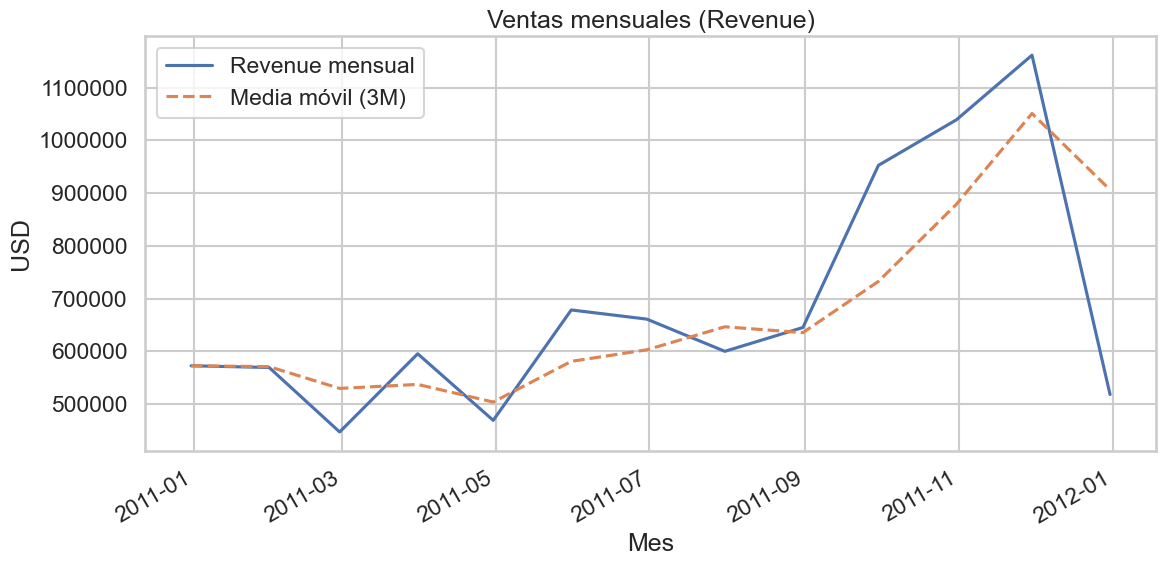

Guardado: C:\Users\jairo\Documents\Maestria\primer semestre\Fundamentos_en_Ciencia_de_datos\Tareas\1\online-retail-project\reports\01_revenue_mensual.png


In [7]:
# Agregación mensual
monthly = (
    df.dropna(subset=["InvoiceDate"])
      .set_index("InvoiceDate")
      .resample("ME")["Revenue"].sum()
      .reset_index()
)
print(monthly.head(3))
# Línea + media móvil (suavizado)
monthly["Revenue_ma3"] = monthly["Revenue"].rolling(3, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=monthly, x="InvoiceDate", y="Revenue", ax=ax, label="Revenue mensual")
sns.lineplot(data=monthly, x="InvoiceDate", y="Revenue_ma3", ax=ax, label="Media móvil (3M)", linestyle="--")

ax.set_title("Ventas mensuales (Revenue)")
ax.set_xlabel("Mes")
ax.set_ylabel("USD")
ax.ticklabel_format(style="plain", axis="y")
fig.autofmt_xdate()
fig.tight_layout()

path1 = OUTDIR / "01_revenue_mensual.png"
fig.savefig(path1, dpi=150, bbox_inches="tight")
plt.show()

print(f"Guardado: {path1.resolve()}")


# Concentración geográfica: Top 10 países por Revenue

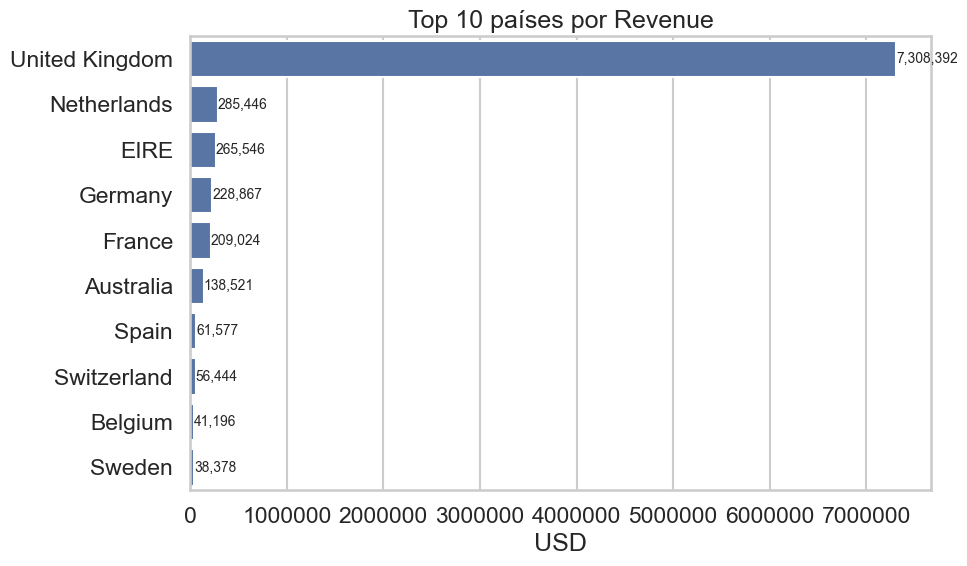

Guardado: C:\Users\jairo\Documents\Maestria\primer semestre\Fundamentos_en_Ciencia_de_datos\Tareas\1\online-retail-project\reports\02_top_paises_revenue.png


In [8]:
# Revenue por país
top_countries = (
    df.groupby("Country", dropna=True)["Revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .reset_index()
)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=top_countries, x="Revenue", y="Country", ax=ax)
ax.set_title("Top 10 países por Revenue")
ax.set_xlabel("USD")
ax.set_ylabel("")
ax.ticklabel_format(style="plain", axis="x")

# Anotar valores al final de las barras
for p in ax.patches:
    w = p.get_width()
    ax.text(w, p.get_y() + p.get_height()/2, f"{w:,.0f}", va="center", ha="left", fontsize=10)

fig.tight_layout()
path2 = OUTDIR / "02_top_paises_revenue.png"
fig.savefig(path2, dpi=150, bbox_inches="tight")
plt.show()

print(f"Guardado: {path2.resolve()}")


# Mapa de calor: Revenue por país (Top 10) y mes

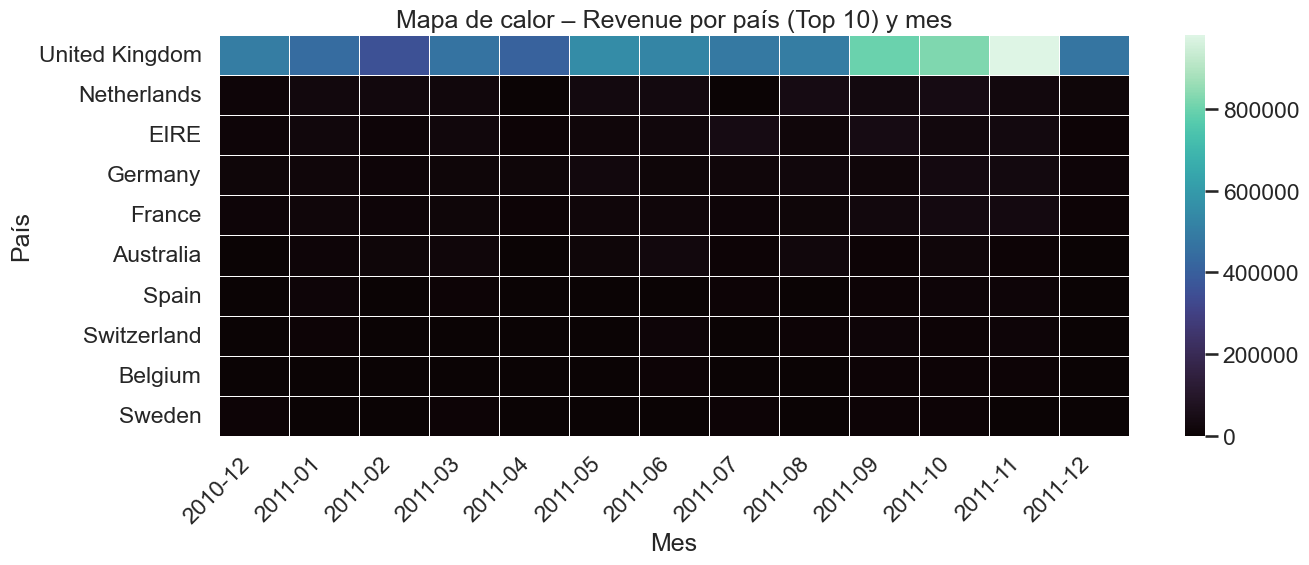

Guardado: C:\Users\jairo\Documents\Maestria\primer semestre\Fundamentos_en_Ciencia_de_datos\Tareas\1\online-retail-project\reports\03_heatmap_pais_mes.png


In [10]:
# 1) Top 10 países por revenue total
top10 = (
    df.groupby("Country", dropna=True)["Revenue"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
      .index
)

# 2) Preparar YearMonth y filtrar a top10
tmp = df[df["Country"].isin(top10)].copy()
tmp["YearMonth"] = tmp["InvoiceDate"].dt.to_period("M")

# 3) Pivot (filas=país, columnas=mes, valores=Revenue)
pivot = (
    tmp.pivot_table(index="Country", columns="YearMonth",
                    values="Revenue", aggfunc="sum", fill_value=0)
)

# 4) Ordenar filas por revenue total descendente (¡aquí estaba el error!)
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

# 5) Ordenar columnas cronológicamente
pivot = pivot.sort_index(axis=1)

# 6) Dibujar
fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pivot, cmap="mako", linewidths=.5, linecolor="white", ax=ax)

# Etiquetas bonitas en el eje X
ax.set_xticklabels([str(p) for p in pivot.columns], rotation=45, ha="right")

ax.set_title("Mapa de calor – Revenue por país (Top 10) y mes")
ax.set_xlabel("Mes")
ax.set_ylabel("País")
fig.tight_layout()

OUTDIR = Path("..") / "reports"
OUTDIR.mkdir(parents=True, exist_ok=True)
path3 = OUTDIR / "03_heatmap_pais_mes.png"
fig.savefig(path3, dpi=150, bbox_inches="tight")
plt.show()

print(f"Guardado: {path3.resolve()}")

# Cargar Datos sin UK

In [12]:
# Asegurar tipos y Revenue
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df["Quantity"]    = pd.to_numeric(df["Quantity"], errors="coerce")
df["UnitPrice"]   = pd.to_numeric(df["UnitPrice"], errors="coerce")
df["Revenue"]     = df["Quantity"] * df["UnitPrice"]

# Filtrar países ≠ United Kingdom
df_no_uk = df.loc[df["Country"].notna() & (df["Country"] != "United Kingdom")].copy()


# Tendencia temporal: Ventas mensuales (Revenue) sin UK

C:\Users\jairo\AppData\Local\Temp\ipykernel_18428\2679432908.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["Revenue"].sum()


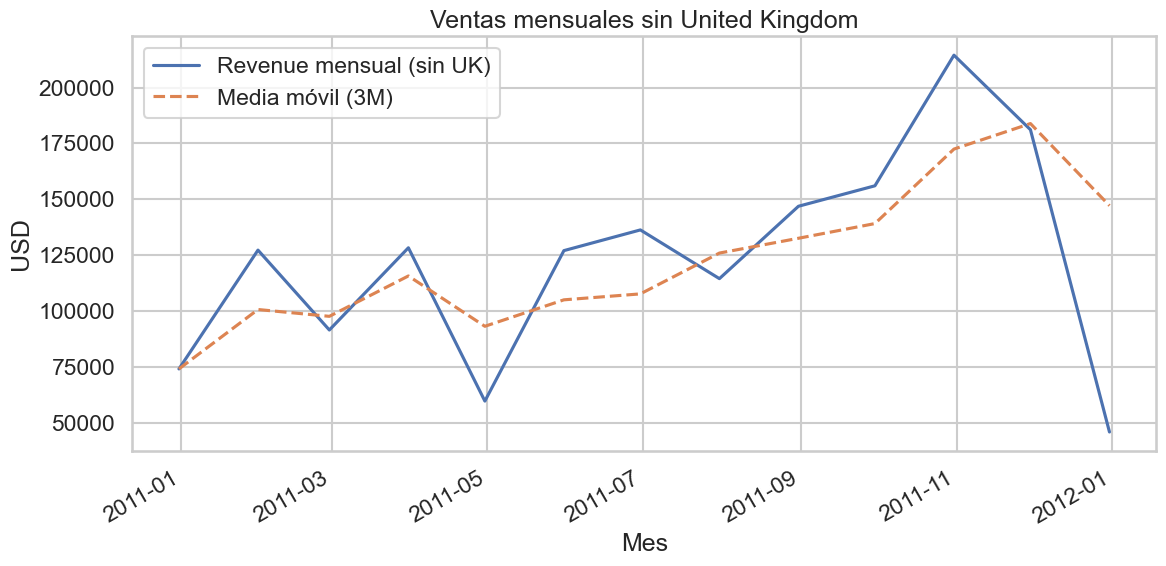

Guardado: C:\Users\jairo\Documents\Maestria\primer semestre\Fundamentos_en_Ciencia_de_datos\Tareas\1\online-retail-project\reports\01_revenue_mensual_sin_uk.png


In [13]:
monthly_no_uk = (
    df_no_uk.dropna(subset=["InvoiceDate"])
            .set_index("InvoiceDate")
            .resample("M")["Revenue"].sum()
            .reset_index()
)
monthly_no_uk["Revenue_ma3"] = monthly_no_uk["Revenue"].rolling(3, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=monthly_no_uk, x="InvoiceDate", y="Revenue", ax=ax, label="Revenue mensual (sin UK)")
sns.lineplot(data=monthly_no_uk, x="InvoiceDate", y="Revenue_ma3", ax=ax, label="Media móvil (3M)", linestyle="--")
ax.set_title("Ventas mensuales sin United Kingdom")
ax.set_xlabel("Mes"); ax.set_ylabel("USD"); ax.ticklabel_format(style="plain", axis="y")
fig.autofmt_xdate(); fig.tight_layout()

p1 = OUTDIR / "01_revenue_mensual_sin_uk.png"
fig.savefig(p1, dpi=150, bbox_inches="tight"); plt.show()
print("Guardado:", p1.resolve())


# Concentración geográfica: Top 10 países por Revenue sin UK

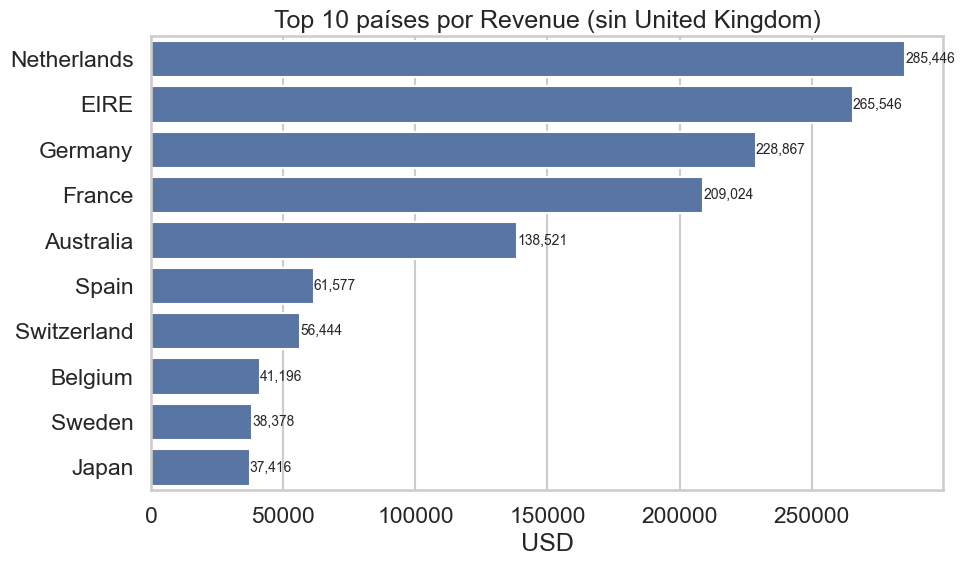

Guardado: C:\Users\jairo\Documents\Maestria\primer semestre\Fundamentos_en_Ciencia_de_datos\Tareas\1\online-retail-project\reports\02_top_paises_revenue_sin_uk.png


In [15]:
top_countries_no_uk = (
    df_no_uk.groupby("Country", dropna=True)["Revenue"]
            .sum().sort_values(ascending=False).head(10).reset_index()
)

fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=top_countries_no_uk, x="Revenue", y="Country", ax=ax)
ax.set_title("Top 10 países por Revenue (sin United Kingdom)")
ax.set_xlabel("USD"); ax.set_ylabel(""); ax.ticklabel_format(style="plain", axis="x")

for p in ax.patches:
    w = p.get_width()
    ax.text(w, p.get_y() + p.get_height()/2, f"{w:,.0f}", va="center", ha="left", fontsize=10)

fig.tight_layout()
p2 = OUTDIR / "02_top_paises_revenue_sin_uk.png"
fig.savefig(p2, dpi=150, bbox_inches="tight"); plt.show()
print("Guardado:", p2.resolve())


# Mapa de calor: Revenue por país (Top 10) y mes sin UK

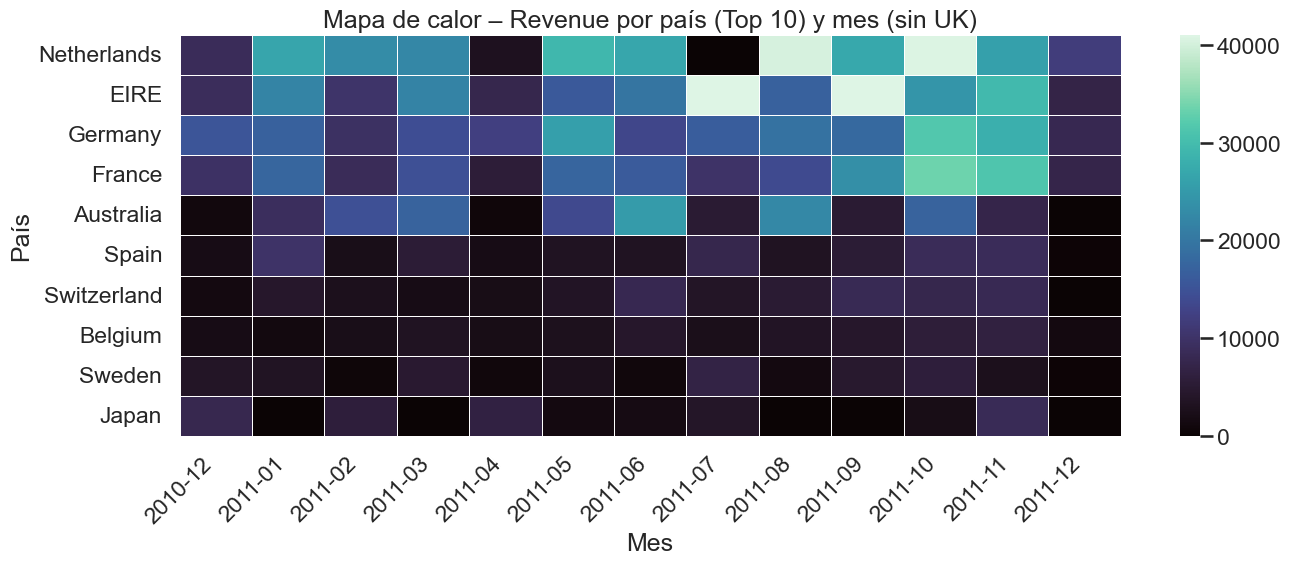

Guardado: C:\Users\jairo\Documents\Maestria\primer semestre\Fundamentos_en_Ciencia_de_datos\Tareas\1\online-retail-project\reports\03_heatmap_pais_mes_sin_uk.png


In [18]:
# Top 10 países sin UK
top10_no_uk = (
    df_no_uk.groupby("Country", dropna=True)["Revenue"]
            .sum().sort_values(ascending=False).head(10).index
)

tmp = df_no_uk[df_no_uk["Country"].isin(top10_no_uk)].copy()
tmp["YearMonth"] = tmp["InvoiceDate"].dt.to_period("M")

pivot = tmp.pivot_table(index="Country", columns="YearMonth",
                        values="Revenue", aggfunc="sum", fill_value=0)

# Ordenar filas por revenue total desc y columnas cronológicas
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot = pivot.sort_index(axis=1)

fig, ax = plt.subplots(figsize=(14,6))
sns.heatmap(pivot, cmap="mako", linewidths=.5, linecolor="white", ax=ax)
ax.set_title("Mapa de calor – Revenue por país (Top 10) y mes (sin UK)")
ax.set_xlabel("Mes"); ax.set_ylabel("País")
ax.set_xticklabels([str(p) for p in pivot.columns], rotation=45, ha="right")
fig.tight_layout()

p3 = OUTDIR / "03_heatmap_pais_mes_sin_uk.png"
fig.savefig(p3, dpi=150, bbox_inches="tight"); plt.show()
print("Guardado:", p3.resolve())


In [21]:
df_no_uk.groupby("Country", dropna=True)["Revenue"].sum().sort_values(ascending=False)

Country
Netherlands             285446.34
EIRE                    265545.90
Germany                 228867.14
France                  209024.05
Australia               138521.31
Spain                    61577.11
Switzerland              56443.95
Belgium                  41196.34
Sweden                   38378.33
Japan                    37416.37
Norway                   36165.44
Portugal                 33439.89
Finland                  22546.08
Singapore                21279.29
Channel Islands          20450.44
Denmark                  18955.34
Italy                    17483.24
Cyprus                   13590.38
Austria                  10198.68
Poland                    7334.65
Israel                    7221.69
Greece                    4760.52
Iceland                   4310.00
Canada                    3666.38
USA                       3580.39
Malta                     2725.59
Unspecified               2667.07
United Arab Emirates      1902.28
Lebanon                   1693.88
Lithua